# Lab 2.3: Introduction to LangGraph

LangGraph is a library for building stateful, multi-actor applications with LLMs. It extends LangChain to allow for cycles/loops in your graph.

## Key Concepts
1. **State**: A shared data structure (usually a TypedDict) that evolves as the graph executes.
2. **Nodes**: Functions that accept the current state and return an update to the state.
3. **Edges**: Control flow rules (standard or conditional) that determine the next node.

In [1]:
# 1. Install Dependencies
print("Installing dependencies...")
%pip install -qU langchain-groq langchain-community langgraph
print("Dependencies installed.")

Installing dependencies...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.4/157.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 1.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
Dependencies installed.


In [2]:
# 2. Setup API Keys
import getpass
import os

if "GROQ_API_KEY" not in os.environ:
    os.environ["GROQ_API_KEY"] = getpass.getpass("Enter your Groq API Key: ")

Enter your Groq API Key: ··········


## 3. Define the State
The state tracks messages in our conversation.

In [3]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

# State definition
# We use TypedDict to define the structure of our state.
# 'messages' is a list that will store the conversation history.
# Annotated[list, add_messages] tells LangGraph that when a node returns a new message,
# it should be APPENDED to the existing list (using add_messages), rather than overwriting it.
class State(TypedDict):
    messages: Annotated[list, add_messages]

## 4. Define Nodes
We will creation a simple 'chatbot' node that calls the LLM.

In [4]:
from langchain_groq import ChatGroq
from langchain_core.messages import SystemMessage

# Initialize the LLM (Large Language Model)
# We are using Groq for fast inference.
print("Initializing LLM...")
llm = ChatGroq(
    model="qwen/qwen3-32b",
    temperature=0,
    reasoning_format="parsed"
)
print("LLM Initialized.")

Initializing LLM...
LLM Initialized.


In [5]:
def banking_assistant(state: State):
    """
    This function acts as a node in our graph.
    It takes the current state as input and returns a dictionary with updates to the state.
    """
    # Enforce banking persona using a SystemMessage
    system_message = SystemMessage(content="You are a helpful customer service representative for Wells Fargo. You assist customers with their banking inquiries. Be professional and friendly.")

    # Combine system message with conversation history
    messages = [system_message] + state["messages"]

    # Call the LLM and return the result.
    # The key 'messages' in the return dictionary matches the key in our State definition.
    return {"messages": [llm.invoke(messages)]}

In [6]:
# Let's test the component in isolation before building the graph
print("--- Testing banking_assistant Node ---")

# Create a dummy state with a sample user message
from langchain_core.messages import HumanMessage
dummy_state = {"messages": [HumanMessage(content="Hello, can you help me?")]}

# Run the function
response = banking_assistant(dummy_state)

# Print the output
print("Node Output:", response["messages"][-1].content)
print("----------------------------------------")

--- Testing banking_assistant Node ---
Node Output: Hello! Of course, I'd be happy to help. How can I assist you today?
----------------------------------------


## 5. Build the Graph
We use `StateGraph` to wire everything together.

In [7]:
from langgraph.graph import StateGraph, START, END

# Initialize the graph builder with our State structure
graph_builder = StateGraph(State)

# Add nodes to the graph
# The first argument is the name of the node (string)
# The second argument is the function to call
graph_builder.add_node("banking_assistant", banking_assistant)

# Define the flow (Edges)
# START -> banking_assistant -> END
graph_builder.add_edge(START, "banking_assistant")
graph_builder.add_edge("banking_assistant", END)

# Compile the graph into a runnable application
graph = graph_builder.compile()
print("Graph compiled successfully.")

Graph compiled successfully.


## 6. Visualization
You can visualize the graph structure (requires `graphviz`, optional here).

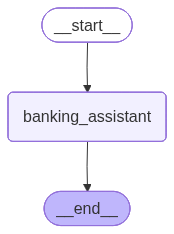

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies; ignore if it fails in basic environment
    pass

## 7. Run the Graph

In [9]:
user_input = "What are the daily withdrawal limits for a standard checking account?"

# Invoke the graph
print(f"User Input: {user_input}")
print("Processing...")
for event in graph.stream({"messages": [("user", user_input)]}):
    for value in event.values():
        print("Wells Fargo Assistant:", value["messages"][-1].content)

User Input: What are the daily withdrawal limits for a standard checking account?
Processing...
Wells Fargo Assistant: At Wells Fargo, the daily withdrawal limits for a **standard checking account** can vary depending on the type of transaction and your specific account terms. Here’s a general overview:

1. **In-Branch or ATM Withdrawals**:  
   - There is **no set daily limit** for in-branch or ATM withdrawals, but the bank may require a valid ID and could ask for the reason if the amount is unusually high.  
   - **ATM limits** typically range from **$500 to $1,000 per day**, depending on your account type and history. New accounts may have lower temporary limits.

2. **Online/Mobile Transfers**:  
   - Transfers to external accounts (e.g., via the app or online banking) may have daily limits, often up to **$2,500**, but this can vary.  
   - Transfers to your own accounts (e.g., from checking to savings) are usually unlimited.

3. **Debit Card Purchases**:  
   - Daily purchase limi